In [5]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

Defining some hyper parameters

In [47]:
IMAGE_SIZE = [100,100]
epochs = 5
batch_size =32

# Dataset : Fruits 360 ( https://www.kaggle.com/datasets/moltean/fruits )

#I reduced the total classes to 10 (instead of orignal 131 at that time) to reduce data size to save some training time
train_path = "fruits-360-small/Training"
test_path = "fruits-360-small/Test"

image_files = glob(train_path+"/*/*.jp*g")
test_image_files = glob(test_path+"/*/*.jp*g")
folders = glob(train_path+'/*')


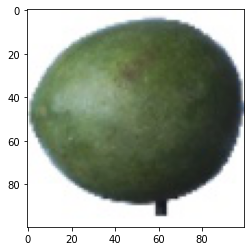

In [48]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

Modelling

In [49]:
vgg = VGG16(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
x = Dense(1000,activation="relu")(x)
prediction = Dense(len(folders),activation = 'softmax')(x)
model = Model(inputs = vgg.input, outputs=prediction)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [59]:
model.compile(loss = "categorical_crossentropy",
             optimizer = "adam",
             metrics = ["accuracy"])

Data Augmentation instance

In [60]:
gen = ImageDataGenerator(
                          rotation_range=20,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          shear_range=0.1,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          vertical_flip=True,
                          preprocessing_function=preprocess_input
)

test_gen = gen.flow_from_directory(train_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k
# print(labels)

Found 4787 images belonging to 10 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Eggplant': 3, 'Kiwi': 4, 'Lemon': 5, 'Mango': 6, 'Peach': 7, 'Raspberry': 8, 'Strawberry': 9}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -108.736664 max: 151.061


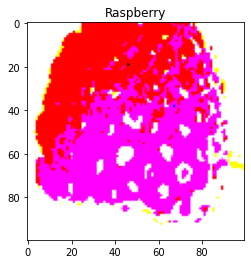

In [61]:
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

Model Training

In [62]:
train_generator = gen.flow_from_directory(train_path,
                                         target_size = IMAGE_SIZE,
                                         shuffle = True,
                                         batch_size = batch_size)
test_generator = gen.flow_from_directory(test_path,
                                         target_size = IMAGE_SIZE,
                                         shuffle = True,
                                         batch_size = batch_size)
res = model.fit_generator(train_generator, 
                          validation_data = test_generator,
                         epochs = epochs
                         )

Found 4787 images belonging to 10 classes.
Found 1605 images belonging to 10 classes.
Epoch 1/5
150/150 [==============================] - 125s 833ms/step - loss: 1.2137 - acc: 0.9659 - val_loss: 1.5604 - val_acc: 0.9695
Epoch 2/5
150/150 [==============================] - 124s 828ms/step - loss: 0.1423 - acc: 0.9948 - val_loss: 1.0814 - val_acc: 0.9788
Epoch 3/5
150/150 [==============================] - 130s 865ms/step - loss: 0.3253 - acc: 0.9906 - val_loss: 0.3258 - val_acc: 0.9913
Epoch 4/5
150/150 [==============================] - 133s 888ms/step - loss: 0.1200 - acc: 0.9952 - val_loss: 0.4740 - val_acc: 0.9857
Epoch 5/5
150/150 [==============================] - 125s 835ms/step - loss: 0.1060 - acc: 0.9971 - val_loss: 0.6719 - val_acc: 0.9788


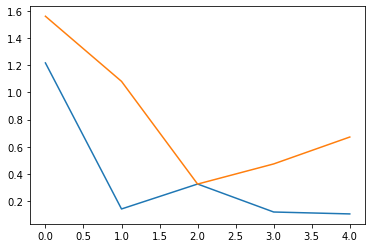

In [63]:
plt.plot(res.history["loss"] , label = "loss")
plt.plot(res.history["val_loss"] , label = "val_loss")
plt.show()

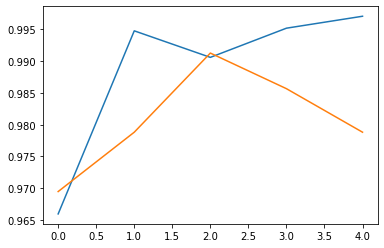

In [64]:
plt.plot(res.history["acc"] , label = "acc")
plt.plot(res.history["val_acc"] , label = "val_acc")
plt.show()

It slightly overfitted in the end but thats ok !!